In [6]:
import pandas as pd
import numpy as np
import scanpy as sc
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_samples, silhouette_score

import sys
sys.path.append('~/SCALEX/script')
from metrics import *
plt.rc('font', family='Helvetica')
plt.rcParams['pdf.fonttype'] = 42

In [3]:
palette = { 'SCALEX': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
            'Raw': (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
            'Seurat_v3': (1.0, 0.4980392156862745, 0.054901960784313725),
            'Harmony':  (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
            'Conos':(0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
            'BBKNN': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
            'Scanorama': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
            'FastMNN':  (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
            'scVI': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
            'online_iNMF':(0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
            'LIGER':(0.6509803921568628, 0.807843137254902, 0.8901960784313725)}

In [ ]:
datasets =['pancreas', 'heart','liver','NSCLC','PBMC']
methods = ['Raw', 'SCALEX','Seurat_v3','Harmony','Conos','BBKNN','scVI','Scanorama','FastMNN','online_iNMF','LIGER']

### overcorrection_score

In [2]:
import scipy
from sklearn.neighbors import NearestNeighbors, KNeighborsRegressor
def overcorrection_score(emb, celltype, n_neighbors=100, n_pools=100, n_samples_per_pool=100, seed=124):
    """
    """
    n_neighbors = min(n_neighbors, len(emb) - 1)
    nne = NearestNeighbors(n_neighbors=1 + n_neighbors, n_jobs=8)
    nne.fit(emb)
    kmatrix = nne.kneighbors_graph(emb) - scipy.sparse.identity(emb.shape[0])

    score = 0
    celltype_ = np.unique(celltype)
    celltype_dict = celltype.value_counts().to_dict()
    
    N_celltype = len(celltype_)

    for t in range(n_pools):
        indices = np.random.choice(np.arange(emb.shape[0]), size=n_samples_per_pool, replace=False)
        score += np.mean([np.mean(celltype[kmatrix[i].nonzero()[1]][:min(celltype_dict[celltype[i]], n_neighbors)] == celltype[i]) for i in indices])

    return 1-score / float(n_pools)

In [ ]:
oc_score = pd.DataFrame(index = datasets, columns = methods)

for dataset in datasets:
    adata = sc.read_h5ad('~/SCALEX/results/{}/adata.h5ad'.format(dataset))

    for method in methods:
        if method+'_umap' in list(adata.obsm.keys()):
            oc_score.loc[dataset, method] = overcorrection_score(adata.obsm[method+'_umap'], adata.obs['celltype'])
        else:
            oc_score.loc[dataset, method] = 0
            pass


findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


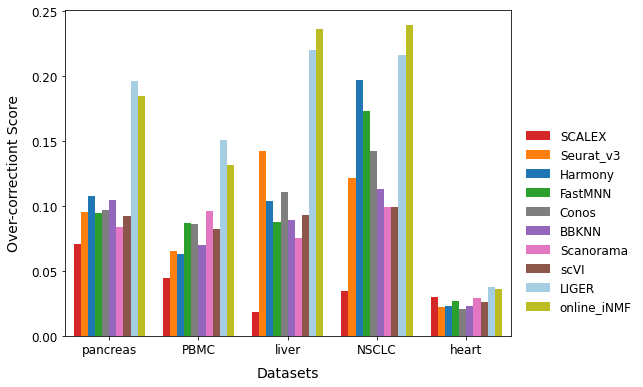

In [8]:
# score = pd.read_csv('~/SCALEX/notebook/benchmark/overcorrect_benchmark.txt', sep='\t', index_col=0)

datasets = list(score.index)
methods = list(score.columns)
palette = { 'SCALEX': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
            'Raw': (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
            'Seurat_v3': (1.0, 0.4980392156862745, 0.054901960784313725),
            'Harmony':  (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
            'Conos':(0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
            'BBKNN': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
            'Scanorama': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
            'FastMNN':  (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
            'scVI': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
            'online_iNMF':(0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
            'LIGER':(0.6509803921568628, 0.807843137254902, 0.8901960784313725),}

score = pd.DataFrame({'Dataset':np.repeat(datasets, len(methods)),
                      'Method': methods* len(datasets),
                      'overcorrect_score': np.reshape(score.values, (1, -1)).squeeze(),})
score = score[score['Method'] !='Raw']
legend_params = {'loc': 'center left',
                 'bbox_to_anchor':(1.01, 0.35),
                 'fontsize': 12,
                 'ncol': 1,
                 'frameon': False,
                 'markerscale': 1
                }

plt.rcParams['savefig.dpi'] = 100
plt.rcParams['figure.dpi'] = 100
plt.figure(figsize=(8,6))
fig = sns.barplot(x='Dataset', y='overcorrect_score', data=score, hue='Method',palette=palette, saturation=1)
plt.ylabel('Over-correctiont Score',fontsize=14, labelpad=10)
plt.xlabel('Datasets',fontsize=14, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('',fontsize=16,y=1.02)
plt.legend(**legend_params)